<a href="https://colab.research.google.com/github/ziqlu0722/Info7374-GitHub-repo/blob/master/Assignment_2/RMS_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
  

Saving tiny-imagenet-200.zip to tiny-imagenet-200.zip
User uploaded file "tiny-imagenet-200.zip" with length 248100043 bytes


In [0]:
import os
import pickle
import scipy.misc
import numpy as np
from scipy.misc import imread

In [0]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['tiny-imagenet-200.zip']), 'r')
data.extractall("tiny-imagenet-200")

In [0]:
def load_tiny_imagenet(path, wnids_path, resize='false', num_classes=200, dtype=np.float32):
  """
  Load TinyImageNet. Each of TinyImageNet-100-A, TinyImageNet-100-B, and
  TinyImageNet-200 have the same directory structure, so this can be used
  to load any of them.
  Inputs:
  - path: String giving path to the directory to load.
  - dtype: numpy datatype used to load the data.
  Returns: A tuple of
  - class_names: A list where class_names[i] is a list of strings giving the
    WordNet names for class i in the loaded dataset.
  - X_train: (N_tr, 3, 64, 64) array of training images
  - y_train: (N_tr,) array of training labels
  - X_val: (N_val, 3, 64, 64) array of validation images
  - y_val: (N_val,) array of validation labels
  - X_test: (N_test, 3, 64, 64) array of testing images.
  - y_test: (N_test,) array of test labels; if test labels are not available
    (such as in student code) then y_test will be None.
  """
  # First load wnids
  wnids_file = os.path.join(wnids_path, 'wnids.txt')
  with open(os.path.join(path, wnids_file), 'r') as f:
    wnids = [x.strip() for x in f]

  # Map wnids to integer labels
  wnid_to_label = {wnid: i for i, wnid in enumerate(wnids)}

  # Use words.txt to get names for each class
  words_file = os.path.join(wnids_path, 'words.txt')
  with open(os.path.join(path, words_file), 'r') as f:
    wnid_to_words = dict(line.split('\t') for line in f)
    for wnid, words in wnid_to_words.items():
      wnid_to_words[wnid] = [w.strip() for w in words.split(',')]
  class_names = [wnid_to_words[wnid] for wnid in wnids]

  # Next load training data.
  X_train = []
  y_train = []
  for i, wnid in enumerate(wnids):
    if (i + 1) % 20 == 0:
      print('loading training data for synset %d / %d' % (i + 1, len(wnids)))
    # To figure out the filenames we need to open the boxes file
    boxes_file = os.path.join(path, 'train', wnid, '%s_boxes.txt' % wnid)
    with open(boxes_file, 'r') as f:
      filenames = [x.split('\t')[0] for x in f]
    num_images = len(filenames)
    
    if resize.lower() == 'true':
      X_train_block = np.zeros((num_images, 3, 32, 32), dtype=dtype)
    else:
      X_train_block = np.zeros((num_images, 3, 64, 64), dtype=dtype)
    
    y_train_block = wnid_to_label[wnid] * np.ones(num_images, dtype=np.int64)
    for j, img_file in enumerate(filenames):
      img_file = os.path.join(path, 'train', wnid, 'images', img_file)
      img = imread(img_file)
      
      if resize.lower() == 'true':
        img = scipy.misc.imresize(img, (32, 32, 3))
      if img.ndim == 2:
        ## grayscale file
        if resize.lower() == 'true':
          img.shape = (32, 32, 1)
        else:
          img.shape = (64, 64, 1)
      X_train_block[j] = img.transpose(2, 0, 1)
    X_train.append(X_train_block)
    y_train.append(y_train_block)
      
  # We need to concatenate all training data
  X_train = np.concatenate(X_train, axis=0)
  y_train = np.concatenate(y_train, axis=0)
  
  # Next load validation data
  with open(os.path.join(path, 'val', 'val_annotations.txt'), 'r') as f:
    img_files = []
    val_wnids = []
    for line in f:
      # Select only validation images in chosen wnids set
      if line.split()[1] in wnids:
        img_file, wnid = line.split('\t')[:2]
        img_files.append(img_file)
        val_wnids.append(wnid)
    num_val = len(img_files)
    y_val = np.array([wnid_to_label[wnid] for wnid in val_wnids])
    
    if resize.lower() == 'true':
      X_val = np.zeros((num_val, 3, 32, 32), dtype=dtype)
    else:
      X_val = np.zeros((num_val, 3, 64, 64), dtype=dtype)
 
    for i, img_file in enumerate(img_files):
      img_file = os.path.join(path, 'val', 'images', img_file)
      img = imread(img_file)
      if resize.lower() == 'true':
        img = scipy.misc.imresize(img, (32, 32, 3))
      if img.ndim == 2:
        if resize.lower() == 'true':
          img.shape = (32, 32, 1)
        else:
          img.shape = (64, 64, 1)

      X_val[i] = img.transpose(2, 0, 1)

  """
  # Next load test images
  # Students won't have test labels, so we need to iterate over files in the
  # images directory.
  img_files = os.listdir(os.path.join(path, 'test', 'images'))
  X_test = np.zeros((len(img_files), 3, 64, 64), dtype=dtype)
  for i, img_file in enumerate(img_files):
    img_file = os.path.join(path, 'test', 'images', img_file)
    img = imread(img_file)
    if img.ndim == 2:
      img.shape = (64, 64, 1)
    X_test[i] = img.transpose(2, 0, 1)
  y_test = None
  y_test_file = os.path.join(path, 'test', 'test_annotations.txt')
  if os.path.isfile(y_test_file):
    with open(y_test_file, 'r') as f:
      img_file_to_wnid = {}
      for line in f:
        line = line.split('\t')
        img_file_to_wnid[line[0]] = line[1]
    y_test = [wnid_to_label[img_file_to_wnid[img_file]] for img_file in img_files]
    y_test = np.array(y_test)
  """
  
  # Omit x_test and y_test because they're unlabeled
  #return class_names, X_train, y_train, X_val, y_val, X_test, y_test
  return class_names, X_train, y_train, X_val, y_val

In [0]:
class_names,X_train, y_train,X_val,y_val = load_tiny_imagenet('/content/tiny-imagenet-200/tiny-imagenet-200',"",resize='true')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


loading training data for synset 20 / 200
loading training data for synset 40 / 200
loading training data for synset 60 / 200
loading training data for synset 80 / 200
loading training data for synset 100 / 200
loading training data for synset 120 / 200
loading training data for synset 140 / 200
loading training data for synset 160 / 200
loading training data for synset 180 / 200
loading training data for synset 200 / 200


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [0]:
from keras.models import Model
from keras.layers import Flatten, Dense

#import register_converters as _register_converters
from keras.preprocessing import image

from keras.applications.vgg16 import VGG16
vgg_model =VGG16(weights='imagenet', input_tensor=None, input_shape=(32,32,3),include_top=False) 

    
x = Flatten()(vgg_model.output)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)

x = Dense(200, activation = 'softmax')(x)


model = Model(inputs = vgg_model.input, outputs = x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [0]:
import keras

x_train = X_train.astype('float32')



x_test = X_val.astype('float32')




In [0]:

x_train /= 255


x_test /= 255

In [0]:

y_train = keras.utils.to_categorical(y_train, len(class_names))



y_val = keras.utils.to_categorical(y_val, len(class_names))

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0),
              metrics=['accuracy'])



history = model.fit(np.array(X_train.transpose(0,3,2,1)), (y_train),
                    epochs=10,
                    batch_size=256,
                    verbose=1,
                    validation_data=(np.array(X_val.transpose(0,3,2,1)),(y_val)))

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 101s 1ms/step - loss: 2.5766 - acc: 0.3825 - val_loss: 3.1069 - val_acc: 0.3062
Epoch 2/10
100000/100000 [==============================] - 98s 979us/step - loss: 2.2399 - acc: 0.4472 - val_loss: 3.0204 - val_acc: 0.3214
Epoch 3/10
100000/100000 [==============================] - 98s 979us/step - loss: 1.9378 - acc: 0.5089 - val_loss: 3.0167 - val_acc: 0.3444
Epoch 4/10
100000/100000 [==============================] - 98s 979us/step - loss: 1.6401 - acc: 0.5730 - val_loss: 3.2894 - val_acc: 0.3410
Epoch 5/10
100000/100000 [==============================] - 98s 980us/step - loss: 1.3575 - acc: 0.6369 - val_loss: 3.5045 - val_acc: 0.3424
Epoch 6/10
100000/100000 [==============================] - 98s 979us/step - loss: 1.0982 - acc: 0.6985 - val_loss: 3.7182 - val_acc: 0.3350
Epoch 7/10
100000/100000 [==============================] - 98s 978us/step - loss: 0.8636 - acc: 0.7575 

Test loss: 4.950302864837647
Test accuracy: 0.33
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


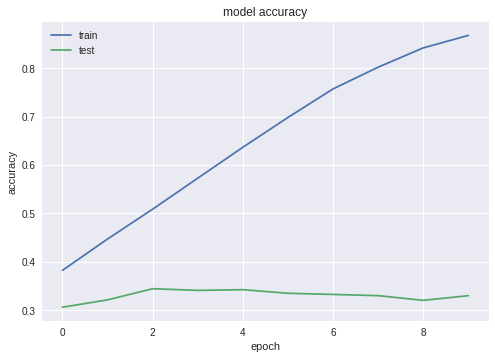

In [0]:
score = model.evaluate(np.array(X_val.transpose(0,3,2,1)),np.array(y_val), verbose=0)
                       
print('Test loss:', score[0])
print('Test accuracy:', score[1])


import matplotlib.pyplot as plt
import numpy

print(history.history.keys())
#summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [0]:
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
#from deepy.layers import Dense, Softmax, Dropout

#import register_converters as _register_converters
from keras.preprocessing import image

from keras.applications.vgg16 import VGG16
vgg_model =VGG16(weights='imagenet', input_tensor=None, input_shape=(32,32,3),include_top=False) 

    
x = Flatten()(vgg_model.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(200, activation = 'softmax')(x)


model = Model(inputs = vgg_model.input, outputs = x)

model.summary()

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0),
              metrics=['accuracy'])



history = model.fit(np.array(X_train.transpose(0,3,2,1)), (y_train),
                    epochs=10,
                    batch_size=256,
                    verbose=1,
                    validation_data=(np.array(X_val.transpose(0,3,2,1)),(y_val)))

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 101s 1ms/step - loss: 5.3121 - acc: 0.0069 - val_loss: 5.2237 - val_acc: 0.0125
Epoch 2/10
100000/100000 [==============================] - 98s 979us/step - loss: 4.6494 - acc: 0.0507 - val_loss: 4.2226 - val_acc: 0.0975
Epoch 3/10
100000/100000 [==============================] - 98s 980us/step - loss: 3.9462 - acc: 0.1319 - val_loss: 3.6665 - val_acc: 0.1866
Epoch 4/10
100000/100000 [==============================] - 98s 981us/step - loss: 3.4886 - acc: 0.2086 - val_loss: 3.4170 - val_acc: 0.2247
Epoch 5/10
100000/100000 [==============================] - 98s 982us/step - loss: 3.1333 - acc: 0.2739 - val_loss: 3.2824 - val_acc: 0.2587
Epoch 6/10
100000/100000 [==============================] - 99s 989us/step - loss: 2.8197 - acc: 0.3329 - val_loss: 3.1214 - val_acc: 0.2955
Epoch 7/10
100000/100000 [==============================] - 98s 982us/step - loss: 2.5254 - acc: 0.3898 

In [0]:
from keras.models import Model
from keras.layers import *
#from deepy.layers import Dense, Softmax, Dropout

#import register_converters as _register_converters
from keras.preprocessing import image

from keras.applications.vgg16 import VGG16
vgg_model =VGG16(weights='imagenet', input_tensor=None, input_shape=(32,32,3),include_top=False) 

    
x = Flatten()(vgg_model.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(4096, activation='relu')(x)
x = Dropout(0.8)(x)

x = Dense(200, activation = 'softmax')(x)


model = Model(inputs = vgg_model.input, outputs = x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0),
              metrics=['accuracy'])



history = model.fit(np.array(X_train.transpose(0,3,2,1)), (y_train),
                    epochs=10,
                    batch_size=256,
                    verbose=1,
                    validation_data=(np.array(X_val.transpose(0,3,2,1)),(y_val)))

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 101s 1ms/step - loss: 5.3101 - acc: 0.0084 - val_loss: 5.1304 - val_acc: 0.0213
Epoch 2/10
100000/100000 [==============================] - 97s 973us/step - loss: 5.0208 - acc: 0.0257 - val_loss: 4.7975 - val_acc: 0.0423
Epoch 3/10
100000/100000 [==============================] - 98s 977us/step - loss: 4.5350 - acc: 0.0622 - val_loss: 4.2518 - val_acc: 0.1017
Epoch 4/10
100000/100000 [==============================] - 98s 977us/step - loss: 4.0261 - acc: 0.1195 - val_loss: 3.8145 - val_acc: 0.1606
Epoch 5/10
100000/100000 [==============================] - 98s 979us/step - loss: 3.6389 - acc: 0.1812 - val_loss: 3.5394 - val_acc: 0.2085
Epoch 6/10
100000/100000 [==============================] - 98s 977us/step - loss: 3.3033 - acc: 0.2377 - val_loss: 3.3268 - val_acc: 0.2475
Epoch 7/10
100000/100000 [==============================] - 98s 978us/step - loss: 3.0097 - acc: 0.2944 

Test loss: 3.3967316055297854
Test accuracy: 0.2984
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


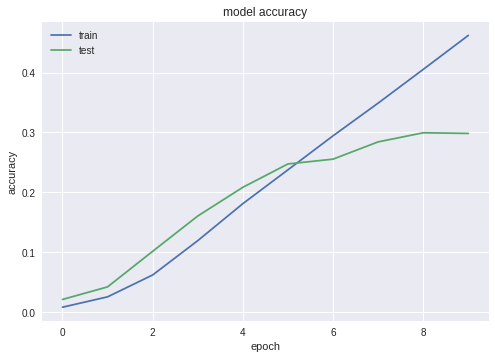

In [0]:
score = model.evaluate(np.array(X_val.transpose(0,3,2,1)),np.array(y_val), verbose=0)
                       
print('Test loss:', score[0])
print('Test accuracy:', score[1])


import matplotlib.pyplot as plt
import numpy

print(history.history.keys())
#summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc']) 
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from keras.models import Model
from keras.layers import *
#from deepy.layers import Dense, Softmax, Dropout

#import register_converters as _register_converters
from keras.preprocessing import image

from keras.applications.vgg16 import VGG16
vgg_model =VGG16(weights='imagenet', input_tensor=None, input_shape=(32,32,3),include_top=False) 

    
x = Flatten()(vgg_model.output)
x = Dense(4096, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)


x = Dense(4096, activation='relu')(x)
x = Dropout(0.8)(x)


x = Dense(200, activation = 'softmax')(x)


model = Model(inputs = vgg_model.input, outputs = x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0),
              metrics=['accuracy'])



history = model.fit(np.array(X_train.transpose(0,3,2,1)), (y_train),
                    epochs=10,
                    batch_size=256,
                    verbose=1,
                    validation_data=(np.array(X_val.transpose(0,3,2,1)),(y_val)))

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 104s 1ms/step - loss: 5.6793 - acc: 0.0063 - val_loss: 5.7842 - val_acc: 0.0050
Epoch 2/10
100000/100000 [==============================] - 98s 983us/step - loss: 5.4167 - acc: 0.0085 - val_loss: 5.3031 - val_acc: 0.0081
Epoch 3/10
100000/100000 [==============================] - 98s 984us/step - loss: 5.3365 - acc: 0.0104 - val_loss: 5.4940 - val_acc: 0.0078
Epoch 4/10
100000/100000 [==============================] - 98s 985us/step - loss: 5.2373 - acc: 0.0138 - val_loss: 5.4035 - val_acc: 0.0057
Epoch 5/10
100000/100000 [==============================] - 98s 983us/step - loss: 5.1417 - acc: 0.0180 - val_loss: 5.5638 - val_acc: 0.0067
Epoch 6/10
100000/100000 [==============================] - 98s 984us/step - loss: 4.9796 - acc: 0.0227 - val_loss: 5.3126 - val_acc: 0.0087
Epoch 7/10
100000/100000 [==============================] - 98s 983us/step - loss: 4.8349 - acc: 0.0294 

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0),
              metrics=['accuracy'])



history = model.fit(np.array(X_train.transpose(0,3,2,1)), (y_train),
                    epochs=25,
                    batch_size=256,
                    verbose=1,
                    validation_data=(np.array(X_val.transpose(0,3,2,1)),(y_val)))

Train on 100000 samples, validate on 10000 samples
Epoch 1/25
100000/100000 [==============================] - 105s 1ms/step - loss: 4.2372 - acc: 0.0852 - val_loss: 4.8825 - val_acc: 0.0382
Epoch 2/25
100000/100000 [==============================] - 99s 990us/step - loss: 4.1057 - acc: 0.1024 - val_loss: 4.8034 - val_acc: 0.0540
Epoch 3/25
100000/100000 [==============================] - 99s 989us/step - loss: 3.9871 - acc: 0.1170 - val_loss: 4.9677 - val_acc: 0.0306
Epoch 4/25
100000/100000 [==============================] - 99s 990us/step - loss: 3.8622 - acc: 0.1341 - val_loss: 4.4702 - val_acc: 0.0927
Epoch 5/25
100000/100000 [==============================] - 99s 991us/step - loss: 3.7530 - acc: 0.1505 - val_loss: 4.3997 - val_acc: 0.0936
Epoch 6/25
100000/100000 [==============================] - 99s 992us/step - loss: 3.6556 - acc: 0.1671 - val_loss: 4.2595 - val_acc: 0.1135
Epoch 7/25
100000/100000 [==============================] - 99s 990us/step - loss: 3.5285 - acc: 0.1850 